We consider a simple conversion reaction

d/dt A = k1 - k2 * A

where A(0) is known and k1, k2 are to be estimated.


Initially we have one measurement at t=10.

In [1]:
import pypesto.optdesign as optdesign
import pypesto.petab
import pypesto.optimize as optimize
import pypesto.visualize as visualize
import numpy as np

In [2]:
importer = pypesto.petab.PetabImporter.from_yaml("conversion_reaction/one_conversion_reaction.yaml")
problem = importer.create_problem()

petab_problem = importer.petab_problem
model=problem.objective.amici_model
obj = problem.objective

optimizer = optimize.ScipyOptimizer()
result = optimize.minimize(problem=problem, optimizer=optimizer, n_starts=10)

In [3]:
# print(result.optimize_result.get_for_key('fval'))
# print(result.optimize_result.as_list(['x'])[0]['x'])

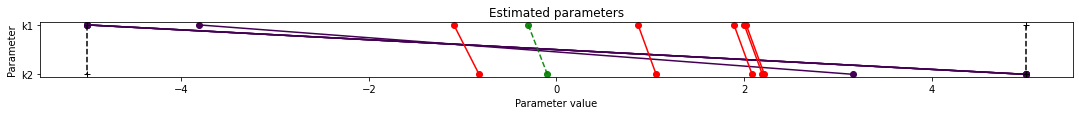

In [4]:
ref = visualize.create_references(
    x=petab_problem.x_nominal_scaled, fval=obj(petab_problem.x_nominal_scaled))

visualize.parameters(result, reference=ref)

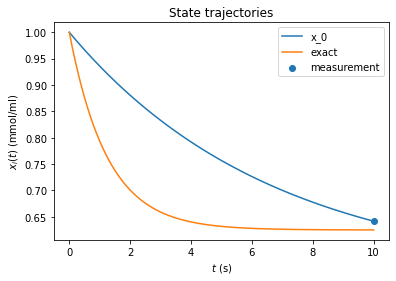

In [5]:
import amici.plotting
model.requireSensitivitiesForAllParameters()
model.setTimepoints(amici.DoubleVector(np.linspace(0, 10, 101)))
model.setParameterScale(amici.ParameterScaling_log10)


temp = result.optimize_result.as_list(['x'])[0]['x']
# these are eg noise parameters for which we have explicit values
missing_params = len(model.getParameterIds()) - len(temp)
for i in range(missing_params):
    temp = np.append(temp, 0)
model.setParameters(temp)

solver = model.getSolver()
solver.setSensitivityMethod(amici.SensitivityMethod_forward)
solver.setSensitivityOrder(amici.SensitivityOrder_first)

# how to run amici now:
rdata = amici.runAmiciSimulation(model, solver, None)
amici.plotting.plotStateTrajectories(rdata)

# correct values
import matplotlib.pyplot as plt
def f(t):
    return (0.625 + 0.375 * np.exp(-0.8*t))
x = np.linspace(0,10,101)
plt.plot(x,f(x), label='exact')
plt.scatter(petab_problem.measurement_df['time'].to_list(),petab_problem.measurement_df['measurement'].to_list(), label='measurement')
plt.legend()

In [6]:
# create list of possible new measurement times to test

problem_list = []
grid = np.linspace(0,10,50)
for index, time  in enumerate(grid):
    dict = {'id': index,
     'condition_df': ['c1'],
     'observable_df': None,
     'measurement_df': ['obs_a', 'c1', time, float('NaN'), 0.02]}
    problem_list.append(dict)

In [7]:
# create problem

design_problem = optdesign.DesignProblem(problem_list=problem_list, n_optimize_runs=10, n_cond_to_add=1, problem=problem,
                                         petab_problem=importer.petab_problem, model=problem.objective.amici_model, result=result)

In [8]:
# Consider the eigenvalues of the initial setting

from pypesto.optdesign.opt_design_helpers import get_design_result
initial = get_design_result(design_problem=design_problem, candidate=None, result=result)
#eigvals from initial setting
print(initial['eigvals'])

[9.09494702e-13 6.66178744e+03]


In [9]:
# run experimental design

design_result = optdesign.run_exp_design(design_problem)

Parameters obtained from history and optimizer do not match: [-0.38324701 -0.19018027], [-0.38325146 -0.19018443]
Parameters obtained from history and optimizer do not match: [-0.38324655 -0.19017981], [-0.38325116 -0.19018408]
Parameters obtained from history and optimizer do not match: [-0.38324664 -0.19017991], [-0.38325021 -0.19018354]
Parameters obtained from history and optimizer do not match: [-1.31756872 -0.97335244], [-1.31759124 -0.97336468]
Parameters obtained from history and optimizer do not match: [-1.32245783 -0.97625859], [-1.32243506 -0.97624545]


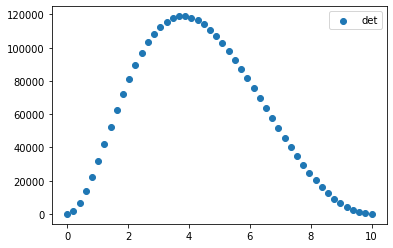

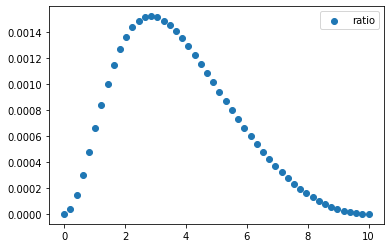

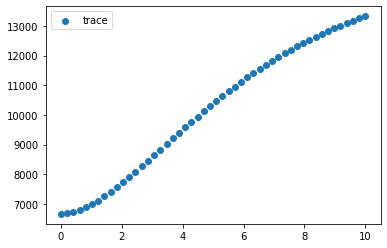

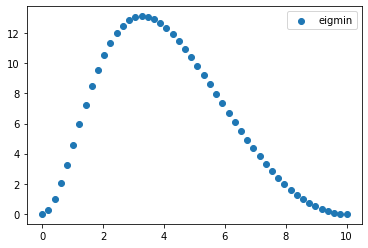

In [11]:
# visualise the criteria values at different time points
import matplotlib.pyplot as plt

plt.scatter(grid, design_result.get_criteria_values('det'), label='det')
plt.legend()
plt.show()
plt.scatter(grid, design_result.get_criteria_values('ratio'), label='ratio')
plt.legend()
plt.show()
plt.scatter(grid, design_result.get_criteria_values('trace'), label='trace')
plt.legend()
plt.show()
plt.scatter(grid, design_result.get_criteria_values('eigmin'), label='eigmin')
plt.legend()
plt.show()

In [12]:
# for i in range(len(design_problem.problem_list)):
#     print(design_result.single_runs[0][i]['petab_problem'].measurement_df)
#     print('\n')

In [13]:
#eigvals after adding different timepoints

design_result.get_criteria_values('eigvals')

[array([   0.        , 6661.78479131]),
 array([2.71673041e-01, 6.67683517e+03]),
 array([9.91312654e-01, 6.71961018e+03]),
 array([2.02581186e+00, 6.78678895e+03]),
 array([3.25838540e+00, 6.87534969e+03]),
 array([4.59062220e+00, 6.98254184e+03]),
 array([5.94279385e+00, 7.10586215e+03]),
 array([   7.25289684, 7243.03362731]),
 array([   8.47489525, 7391.98708009]),
 array([   9.57655105, 7550.84460162]),
 array([  10.53714102, 7717.90473776]),
 array([  11.34525093, 7891.62888973]),
 array([  11.99676299, 8070.62858014]),
 array([  12.49310472, 8253.65362685]),
 array([  12.83978545, 8439.58137829]),
 array([  13.04519879, 8627.40670157]),
 array([  13.11965144, 8816.23218814]),
 array([  13.07461428, 9005.25931769]),
 array([  12.92214642, 9193.78012286]),
 array([  12.67446282, 9381.1693766 ]),
 array([  12.34362259, 9566.87748654]),
 array([  11.94130648, 9750.42383913]),
 array([  11.47866205, 9931.39046706]),
 array([   10.96621155, 10109.41655559]),
 array([   10.41378973, 10